## Lesson 2

In [1]:
import torch
# check for CUDA
if torch.cuda.is_available():
    print('CUDA is available')
else:
    print('CUDA is not available')


CUDA is not available


In [3]:
from fastai.vision.all import *

In [1]:
import torch
torch.__version__

'2.3.0'

In [4]:
import fastai
fastai.__version__

'2.7.15'

In [2]:
def is_cat(x): return x[0].isupper()


In [4]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))


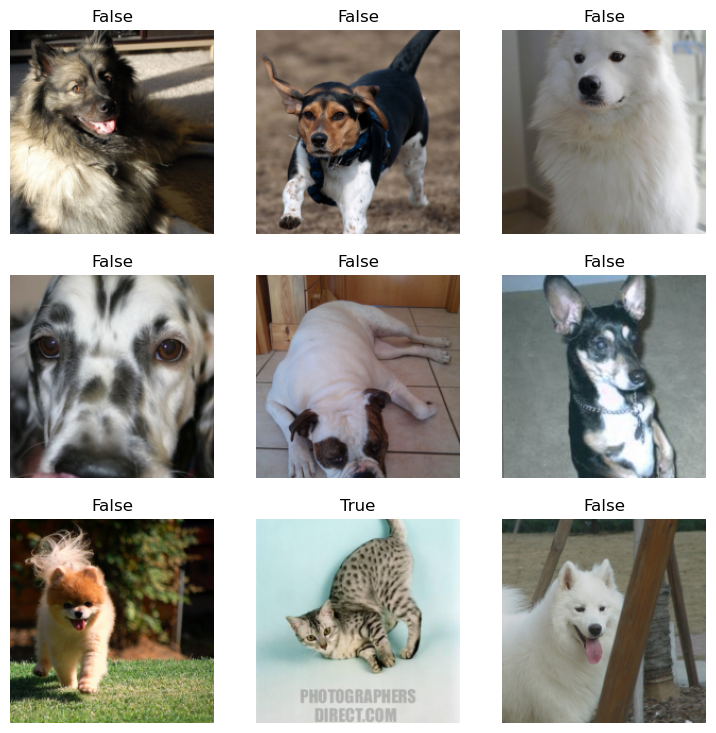

In [5]:
dls.show_batch()

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ron/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.4MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.195426,0.057334,0.017591,02:42


epoch,train_loss,valid_loss,error_rate,time
0,0.074052,0.029908,0.011502,03:25
1,0.035574,0.029314,0.010149,03:17
2,0.019167,0.028332,0.008796,03:19
